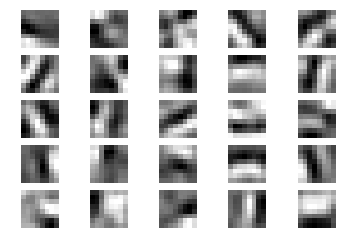

In [3]:
# This piece of software is bound by The MIT License (MIT)
# Copyright (c) 2013 Siddharth Agrawal
# Code written by : Siddharth Agrawal
# Email ID : siddharth.950@gmail.com

import numpy
import math
import time
import scipy.io
import scipy.optimize
import matplotlib.pyplot

###########################################################################################
""" The Sparse Autoencoder class """

class SparseAutoencoder(object):

    #######################################################################################
    """ Initialization of Autoencoder object """

    def __init__(self, visible_size, hidden_size, rho, lamda, beta):
    
        """ Initialize parameters of the Autoencoder object """
    
        self.visible_size = visible_size    # number of input units
        self.hidden_size = hidden_size      # number of hidden units
        self.rho = rho                      # desired average activation of hidden units
        self.lamda = lamda                  # weight decay parameter
        self.beta = beta                    # weight of sparsity penalty term
        
        """ Set limits for accessing 'theta' values """
        
        self.limit0 = 0
        self.limit1 = hidden_size * visible_size
        self.limit2 = 2 * hidden_size * visible_size
        self.limit3 = 2 * hidden_size * visible_size + hidden_size
        self.limit4 = 2 * hidden_size * visible_size + hidden_size + visible_size
        
        """ Initialize Neural Network weights randomly
            W1, W2 values are chosen in the range [-r, r] """
        
        r = math.sqrt(6) / math.sqrt(visible_size + hidden_size + 1)
        
        rand = numpy.random.RandomState(int(time.time()))
        
        W1 = numpy.asarray(rand.uniform(low = -r, high = r, size = (hidden_size, visible_size)))
        W2 = numpy.asarray(rand.uniform(low = -r, high = r, size = (visible_size, hidden_size)))
        
        """ Bias values are initialized to zero """
        
        b1 = numpy.zeros((hidden_size, 1))
        b2 = numpy.zeros((visible_size, 1))

        """ Create 'theta' by unrolling W1, W2, b1, b2 """

        self.theta = numpy.concatenate((W1.flatten(), W2.flatten(),
                                        b1.flatten(), b2.flatten()))

    #######################################################################################
    """ Returns elementwise sigmoid output of input array """
    
    def sigmoid(self, x):
    
        return (1 / (1 + numpy.exp(-x)))

    #######################################################################################
    """ Returns the cost of the Autoencoder and gradient at a particular 'theta' """
        
    def sparseAutoencoderCost(self, theta, input):
        
        """ Extract weights and biases from 'theta' input """
        
        W1 = theta[self.limit0 : self.limit1].reshape(self.hidden_size, self.visible_size)
        W2 = theta[self.limit1 : self.limit2].reshape(self.visible_size, self.hidden_size)
        b1 = theta[self.limit2 : self.limit3].reshape(self.hidden_size, 1)
        b2 = theta[self.limit3 : self.limit4].reshape(self.visible_size, 1)
        
        """ Compute output layers by performing a feedforward pass
            Computation is done for all the training inputs simultaneously """
        
        hidden_layer = self.sigmoid(numpy.dot(W1, input) + b1)
        output_layer = self.sigmoid(numpy.dot(W2, hidden_layer) + b2)
        
        """ Estimate the average activation value of the hidden layers """
        
        rho_cap = numpy.sum(hidden_layer, axis = 1) / input.shape[1]
        
        """ Compute intermediate difference values using Backpropagation algorithm """
        
        diff = output_layer - input
        
        sum_of_squares_error = 0.5 * numpy.sum(numpy.multiply(diff, diff)) / input.shape[1]
        weight_decay         = 0.5 * self.lamda * (numpy.sum(numpy.multiply(W1, W1)) +
                                                   numpy.sum(numpy.multiply(W2, W2)))
        KL_divergence        = self.beta * numpy.sum(self.rho * numpy.log(self.rho / rho_cap) +
                                                    (1 - self.rho) * numpy.log((1 - self.rho) / (1 - rho_cap)))
        cost                 = sum_of_squares_error + weight_decay + KL_divergence
        
        KL_div_grad = self.beta * (-(self.rho / rho_cap) + ((1 - self.rho) / (1 - rho_cap)))
        
        del_out = numpy.multiply(diff, numpy.multiply(output_layer, 1 - output_layer))
        del_hid = numpy.multiply(numpy.dot(numpy.transpose(W2), del_out) + numpy.transpose(numpy.matrix(KL_div_grad)), 
                                 numpy.multiply(hidden_layer, 1 - hidden_layer))
        
        """ Compute the gradient values by averaging partial derivatives
            Partial derivatives are averaged over all training examples """
            
        W1_grad = numpy.dot(del_hid, numpy.transpose(input))
        W2_grad = numpy.dot(del_out, numpy.transpose(hidden_layer))
        b1_grad = numpy.sum(del_hid, axis = 1)
        b2_grad = numpy.sum(del_out, axis = 1)
            
        W1_grad = W1_grad / input.shape[1] + self.lamda * W1
        W2_grad = W2_grad / input.shape[1] + self.lamda * W2
        b1_grad = b1_grad / input.shape[1]
        b2_grad = b2_grad / input.shape[1]
        
        """ Transform numpy matrices into arrays """
        
        W1_grad = numpy.array(W1_grad)
        W2_grad = numpy.array(W2_grad)
        b1_grad = numpy.array(b1_grad)
        b2_grad = numpy.array(b2_grad)
        
        """ Unroll the gradient values and return as 'theta' gradient """
        
        theta_grad = numpy.concatenate((W1_grad.flatten(), W2_grad.flatten(),
                                        b1_grad.flatten(), b2_grad.flatten()))
                                        
        return [cost, theta_grad]

###########################################################################################
""" Normalize the dataset provided as input """

def normalizeDataset(dataset):

    """ Remove mean of dataset """

    dataset = dataset - numpy.mean(dataset)
    
    """ Truncate to +/-3 standard deviations and scale to -1 to 1 """
    
    std_dev = 3 * numpy.std(dataset)
    dataset = numpy.maximum(numpy.minimum(dataset, std_dev), -std_dev) / std_dev
    
    """ Rescale from [-1, 1] to [0.1, 0.9] """
    
    dataset = (dataset + 1) * 0.4 + 0.1
    
    return dataset

###########################################################################################
""" Randomly samples image patches, normalizes them and returns as dataset """

def loadDataset(num_patches, patch_side):

    """ Load images into numpy array """

    images = scipy.io.loadmat('IMAGES.mat')
    images = images['IMAGES']
    
    """ Initialize dataset as array of zeros """
    
    dataset = numpy.zeros((patch_side*patch_side, num_patches))
    
    """ Initialize random numbers for random sampling of images
        There are 10 images of size 512 X 512 """
    
    rand = numpy.random.RandomState(int(time.time()))
    image_indices = rand.randint(512 - patch_side, size = (num_patches, 2))
    image_number  = rand.randint(10, size = num_patches)
    
    """ Sample 'num_patches' random image patches """
    
    for i in range(num_patches):
    
        """ Initialize indices for patch extraction """
    
        index1 = image_indices[i, 0]
        index2 = image_indices[i, 1]
        index3 = image_number[i]
        
        """ Extract patch and store it as a column """
        
        patch = images[index1:index1+patch_side, index2:index2+patch_side, index3]
        patch = patch.flatten()
        dataset[:, i] = patch
    
    """ Normalize and return the dataset """
    
    dataset = normalizeDataset(dataset)
    return dataset

###########################################################################################
""" Visualizes the obtained optimal W1 values as images """

def visualizeW1(opt_W1, vis_patch_side, hid_patch_side):

    """ Add the weights as a matrix of images """
    
    figure, axes = matplotlib.pyplot.subplots(nrows = hid_patch_side,
                                              ncols = hid_patch_side)
    index = 0
                                              
    for axis in axes.flat:
    
        """ Add row of weights as an image to the plot """
    
        image = axis.imshow(opt_W1[index, :].reshape(vis_patch_side, vis_patch_side),
                            cmap = matplotlib.pyplot.cm.gray, interpolation = 'nearest')
        axis.set_frame_on(False)
        axis.set_axis_off()
        index += 1
        
    """ Show the obtained plot """  
        
    matplotlib.pyplot.show()

###########################################################################################
""" Loads data, trains the Autoencoder and visualizes the learned weights """

def executeSparseAutoencoder():

    """ Define the parameters of the Autoencoder """
    
    vis_patch_side = 8      # side length of sampled image patches
    hid_patch_side = 5      # side length of representative image patches
    rho            = 0.01   # desired average activation of hidden units
    lamda          = 0.0001 # weight decay parameter
    beta           = 3      # weight of sparsity penalty term
    num_patches    = 10000  # number of training examples
    max_iterations = 400    # number of optimization iterations

    visible_size = vis_patch_side * vis_patch_side  # number of input units
    hidden_size  = hid_patch_side * hid_patch_side  # number of hidden units
    
    """ Load randomly sampled image patches as dataset """
    
    training_data = loadDataset(num_patches, vis_patch_side)
    
    """ Initialize the Autoencoder with the above parameters """
    
    encoder = SparseAutoencoder(visible_size, hidden_size, rho, lamda, beta)
    
    """ Run the L-BFGS algorithm to get the optimal parameter values """
    
    opt_solution  = scipy.optimize.minimize(encoder.sparseAutoencoderCost, encoder.theta, 
                                            args = (training_data,), method = 'L-BFGS-B', 
                                            jac = True, options = {'maxiter': max_iterations})
    opt_theta     = opt_solution.x
    opt_W1        = opt_theta[encoder.limit0 : encoder.limit1].reshape(hidden_size, visible_size)
    
    """ Visualize the obtained optimal W1 weights """
    
    visualizeW1(opt_W1, vis_patch_side, hid_patch_side)

executeSparseAutoencoder()